# ResNet18 Training

In [5]:
import tarfile
from scipy.io import loadmat
import pandas as pd
import os
import shutil
import torch
from torchvision.datasets import ImageFolder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

## Data Formatting

Extracting Train, Test and Validation with Labels

In [6]:
## Extract from tar file
# import tarfile
# file = tarfile.open("102segmentations.tgz")
# file.extractall('102flowersSegmentations')
# file.close()

## Load mat files
imagelabels = loadmat('imagelabels.mat')
# print(imagelabels)

setid = loadmat('setid.mat')
# print(setid)

## Generate labels df
df_labels = pd.DataFrame(imagelabels['labels'])
df_labels = df_labels.T
df_labels['image_id'] = df_labels.index +1 # rename the column such that it is image_id and labels
df_labels.set_index('image_id', inplace=True) # drop index by making image_id as index
df_labels.columns = ['labels'] # rename the column such that it is image_id and labels

# Generate train, test, validation df
df_setid_trnid = pd.DataFrame(setid['trnid'])
df_setid_valid = pd.DataFrame(setid['valid'])
df_setid_tstid = pd.DataFrame(setid['tstid'])

# Transpose the dataframes
df_setid_trnid = df_setid_trnid.T
df_setid_valid = df_setid_valid.T
df_setid_tstid = df_setid_tstid.T

## DEBUG
# print(df_setid_trnid.shape)
# print(df_setid_valid.shape)
# print(df_setid_tstid.shape)

# Create images df
image_folder = '102flowersSegmentations/segmim'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
df_images = pd.DataFrame(image_files, columns=['image_filename'])
df_images['image_id'] = df_images['image_filename'].str.extract(r'(\d+)').astype(int)

# Merge the dataframes
df_image_labels = df_images.merge(df_labels, on='image_id', how='left') # merge images and labels




Split into datasets

In [7]:
# train, validation and test split
for id in df_setid_trnid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'train'

for id in df_setid_valid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'valid'

for id in df_setid_tstid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'test'

# df_image_labels['set'].value_counts() # DEBUG

df_image_labels.to_csv('image_labels.csv', index=False) # save the dataframe to csv

## Sort into classes
num_classes = df_image_labels['labels'].nunique()
print("Number of classes: ", num_classes)
df_train_distribution = df_image_labels['labels'].value_counts().reset_index() # put information in a df
df_train_distribution.columns = ['class', 'count']
df_train_distribution = df_train_distribution.sort_values('count', ascending=False) # sort by class from 1 to 102

## create a folder for each class
# comment out if the folder already exists

# Create a new directory to store the class folders 
# os.makedirs('102flowers_segmen_split')

# Create a new directory to store the class folders 
# os.makedirs('102flowers_segmen_split/train')
# os.makedirs('102flowers_segmen_split/valid')
# os.makedirs('102flowers_segmen_split/test')

# split based on set in the csv
# for index, row in df_image_labels.iterrows():
#     image_filename = row['image_filename']
#     label = row['labels']
#     set = row['set']
#     src = os.path.join('102flowersSegmentations/segmim', image_filename)
#     dst = os.path.join('102flowers_segmen_split', set, str(label))
#     os.makedirs(dst, exist_ok=True)
#     shutil.copy(src, dst)



Number of classes:  102


In [8]:
# check if cuda is available
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


train_folder = '102flowers_segmen_split/train'
valid_folder = '102flowers_segmen_split/valid'
test_folder = '102flowers_segmen_split/test'

# create datasets
train_dataset = ImageFolder(train_folder) 
valid_dataset = ImageFolder(valid_folder)
test_dataset = ImageFolder(test_folder)

True
cuda


## Data Training

Data Augmentation

In [9]:
# create data generators
train_datagen = ImageDataGenerator( # create a data generator for data augmentation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255) # rescale the images

test_datagen = ImageDataGenerator(rescale=1./255)

# Define the transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create train and validation datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='102flowers_segmen_split/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='102flowers_segmen_split/valid', transform=valid_transforms)

# Create dataloaders for train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Update dataloaders in a dictionary
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

# Update dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset)
}


## Mixup
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


Early Stopping Class

In [10]:
model = models.resnet18(pretrained=True) # load the pretrained model
num_ftrs = model.fc.in_features # get the number of input features for the last layer

model.fc = nn.Linear(num_ftrs, num_classes) # change the last layer to output 102 classes
model = model.to(device) # move the model to the device

# define early stopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss  # We use -val_loss because we want to minimize loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

    def get_best_model_weights(self):
        return self.best_model_wts

c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train function

In [11]:

def train_model(model, criterion, optimizer, scheduler, num_epochs, patience):
    start = time.time()

    early_stopping = EarlyStopping(patience=patience, delta=0)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    accuracy_history = {'train': [], 'valid': []}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Apply mixup in the training phase only
                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)
                    outputs = model(inputs)
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Calculate loss with mixup
                    if phase == 'train':
                        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                    else:
                        loss = criterion(outputs, labels)  # Normal loss in validation

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss
                running_loss += loss.item() * inputs.size(0)

                # Calculate correct predictions differently based on phase
                if phase == 'train':
                    running_corrects += (lam * preds.eq(labels_a).sum().float() + (1 - lam) * preds.eq(labels_b).sum().float()).item()
                else:
                    running_corrects += (preds == labels).sum().item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            accuracy_history[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping check in the validation phase
            if phase == 'valid':
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    model.load_state_dict(early_stopping.get_best_model_weights())
                    return model, accuracy_history

        print()


    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, accuracy_history


Load Resnet and train for different frozen layers

In [2]:
def load_resnet18(num_frozen_layers):
    model = models.resnet18(pretrained=True)
    
    # Freeze layers
    layers_to_freeze = list(model.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for 102 classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 102)
    return model.to(device)


In [ ]:

# Store validation accuracies for each configuration
validation_accuracies = {}

# Parameters for training
num_epochs = 20
learning_rate = 0.001


# Loop over different numbers of frozen layers
for num_frozen_layers in range(0, 6):  # From 0 to 5 layers frozen
    print(f"\nTraining with {num_frozen_layers} frozen layers...")
    
    # Load model with the specified number of frozen layers
    model = load_resnet18(num_frozen_layers)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-4)
    
    # Define the learning rate scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    

    # Train the model
    model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs, patience=5)
    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])
    validation_accuracies[num_frozen_layers] = best_valid_acc

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")

# Find the configuration with the best validation accuracy
best_num_frozen_layers = max(validation_accuracies, key=validation_accuracies.get)
best_accuracy = validation_accuracies[best_num_frozen_layers]

print(f"\nBest configuration: {best_num_frozen_layers} frozen layers")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Training with 0 frozen layers...
Epoch 0/19
----------
train Loss: 4.8182 Acc: 0.0308
valid Loss: 4.8452 Acc: 0.0794

Epoch 1/19
----------
train Loss: 4.2157 Acc: 0.0780
valid Loss: 4.6841 Acc: 0.0990

Epoch 2/19
----------
train Loss: 3.9572 Acc: 0.1273
valid Loss: 3.3537 Acc: 0.2010

Epoch 3/19
----------
train Loss: 3.8079 Acc: 0.1566
valid Loss: 2.7314 Acc: 0.3225

Epoch 4/19
----------
train Loss: 3.6972 Acc: 0.1921
valid Loss: 2.7731 Acc: 0.3216

Epoch 5/19
----------
train Loss: 3.5528 Acc: 0.2147
valid Loss: 3.0200 Acc: 0.2794

Epoch 6/19
----------
train Loss: 3.3005 Acc: 0.2714
valid Loss: 2.6734 Acc: 0.3441

Epoch 7/19
----------
train Loss: 3.0257 Acc: 0.3571
valid Loss: 1.8023 Acc: 0.5490

Epoch 8/19
----------
train Loss: 2.9180 Acc: 0.4046
valid Loss: 1.6563 Acc: 0.5873

Epoch 9/19
----------
train Loss: 2.9004 Acc: 0.4197
valid Loss: 1.6662 Acc: 0.5794

Epoch 10/19
----------
train Loss: 2.9443 Acc: 0.3847
valid Loss: 1.6731 Acc: 0.5902

Epoch 11/19
----------
train L

Plot validation accuracies

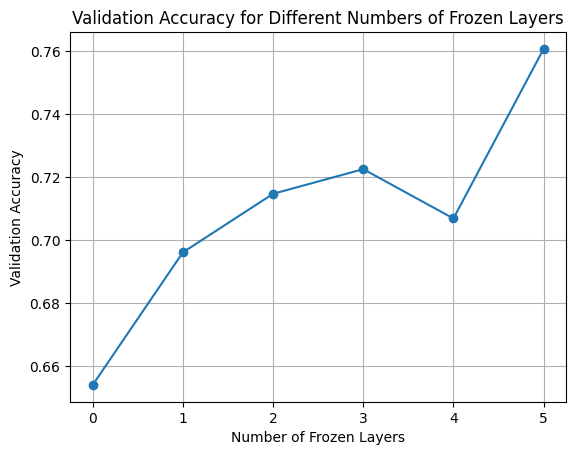

In [11]:
plt.plot(list(validation_accuracies.keys()), list(validation_accuracies.values()), marker='o')
plt.xlabel('Number of Frozen Layers')
plt.ylabel('Validation Accuracy')

plt.title('Validation Accuracy for Different Numbers of Frozen Layers')
plt.grid(True)
plt.show()

5 Frozen Layers has the best accuracy for validation

In [12]:
model = load_resnet18(5)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20, patience=5)

# Save the model
torch.save(model.state_dict(), 'resnet_18(5).pth')



Epoch 0/19
----------
train Loss: 4.7048 Acc: 0.0439
valid Loss: 3.8695 Acc: 0.1324

Epoch 1/19
----------
train Loss: 4.0377 Acc: 0.1155
valid Loss: 3.2770 Acc: 0.2412

Epoch 2/19
----------
train Loss: 3.6659 Acc: 0.2047
valid Loss: 2.5943 Acc: 0.3627

Epoch 3/19
----------
train Loss: 3.4549 Acc: 0.2207
valid Loss: 2.6888 Acc: 0.3559

Epoch 4/19
----------
train Loss: 3.5558 Acc: 0.2367
valid Loss: 2.3352 Acc: 0.4059

Epoch 5/19
----------
train Loss: 3.1140 Acc: 0.3305
valid Loss: 2.0069 Acc: 0.4941

Epoch 6/19
----------
train Loss: 3.1868 Acc: 0.2965
valid Loss: 1.8347 Acc: 0.5569

Epoch 7/19
----------
train Loss: 2.9221 Acc: 0.4037
valid Loss: 1.4685 Acc: 0.6500

Epoch 8/19
----------
train Loss: 2.4660 Acc: 0.5105
valid Loss: 1.3457 Acc: 0.6725

Epoch 9/19
----------
train Loss: 2.6468 Acc: 0.4689
valid Loss: 1.2794 Acc: 0.7078

Epoch 10/19
----------
train Loss: 2.5445 Acc: 0.4992
valid Loss: 1.3081 Acc: 0.7029

Epoch 11/19
----------
train Loss: 2.5633 Acc: 0.5029
valid Loss